In [ ]:
# Modified from 
# https://nbviewer.org/github/ICESat2-SlideRule/sliderule-python/blob/main/examples/single_track_demo.ipynb
# https://github.com/SlideRuleEarth/sliderule-python/blob/main/examples/single_track_demo.ipynb

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import posixpath
import shapely.geometry
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Required libraries: https://pypi.org/project/sliderule/
from sliderule import icesat2, io, sliderule, earthdata, h5

In [3]:
# Configure Session
icesat2.init("slideruleearth.io")

In [4]:
# find granules for a spatial and temporal query
box_lon = [-105, -105, -100, -100, -105]
box_lat = [-75, -77.5, -77.5, -75, -75]
poly = io.to_region(box_lon, box_lat)
resources = earthdata.cmr(short_name='ATL03', polygon=poly, time_start='2018-10-19', time_end='2018-10-20') 
granule = resources[0]

In [5]:
%%time
# regular expression operator for extracting information from files
rx = re.compile(r'(ATL\d{2})(-\d{2})?_(\d{4})(\d{2})(\d{2})(\d{2})'
    r'(\d{2})(\d{2})_(\d{4})(\d{2})(\d{2})_(\d{3})_(\d{2})(.*?).h5$')
# extract parameters from ICESat-2 granule
PRD,HEM,YY,MM,DD,HH,MN,SS,TRK,CYCL,GRN,RL,VRS,AUX=rx.findall(granule).pop()

# Build ATL06 Request
parms = {
    "poly":poly,
    "cnf": 4,
    "ats": 20.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0
}

# Request ATL06 Data
gdf = icesat2.atl06(parms, granule)

# Return DataFrame
print("Reference Ground Tracks: {} to {}".format(min(gdf["rgt"]), max(gdf["rgt"])))
print("Cycle: {} to {}".format(min(gdf["cycle"]), max(gdf["cycle"])))
print("Retrieved {} points from SlideRule".format(len(gdf["h_mean"])))

Reference Ground Tracks: 325 to 325
Cycle: 1 to 1
Retrieved 51999 points from SlideRule
CPU times: total: 188 ms
Wall time: 7.4 s


In [6]:
def s3_retrieve(granule, **kwargs):
    # set default keyword arguments
    kwargs.setdefault('lon_key','longitude')
    kwargs.setdefault('lat_key','latitude')
    kwargs.setdefault('index_key','time')
    kwargs.setdefault('polygon',None)
    # regular expression operator for extracting information from files
    rx = re.compile(r'(ATL\d{2})(-\d{2})?_(\d{4})(\d{2})(\d{2})(\d{2})'
        r'(\d{2})(\d{2})_(\d{4})(\d{2})(\d{2})_(\d{3})_(\d{2})(.*?).h5$')
    # extract parameters from ICESat-2 granule
    PRD,HEM,YY,MM,DD,HH,MN,SS,TRK,CYCL,GRN,RL,VRS,AUX=rx.findall(granule).pop()
    # variables of interest
    if (PRD == 'ATL06'):
        segment_group = "land_ice_segments"
        segment_key = 'segment_id'
        vnames = ['segment_id','delta_time','latitude','longitude',
            'h_li','h_li_sigma','atl06_quality_summary',
            'fit_statistics/dh_fit_dx','fit_statistics/dh_fit_dy',
            'fit_statistics/dh_fit_dx_sigma','fit_statistics/n_fit_photons',
            'fit_statistics/h_expected_rms','fit_statistics/h_robust_sprd',
            'fit_statistics/w_surface_window_final','fit_statistics/h_mean']
    elif (PRD == 'ATL08'):
        segment_group = "land_segments"
        segment_key = 'segment_id_beg'
        vnames = ['segment_id_beg','segment_id_end','delta_time',
            'latitude','longitude','brightness_flag','layer_flag',
            'msw_flag','night_flag','terrain_flg','urban_flag',
            'segment_landcover','segment_snowcover','segment_watermask',
            'terrain/h_te_best_fit','terrain/h_te_uncertainty',
            'terrain/terrain_slope','terrain/n_te_photons',
            'canopy/h_canopy','canopy/h_canopy_uncertainty',
            'canopy/canopy_flag','canopy/n_ca_photons']
    # for each valid beam within the HDF5 file
    frames = []
    gt = dict(gt1l=10,gt1r=20,gt2l=30,gt2r=40,gt3l=50,gt3r=60)
    atlas_sdp_epoch = np.datetime64('2018-01-01T00:00:00')
    kwds = dict(startrow=0,numrows=-1)
    for gtx in ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']:
        geodatasets = [dict(dataset=f'{gtx}/{segment_group}/{v}',**kwds) for v in vnames]
        try:
            # get datasets from s3
            hidatasets = h5.h5p(geodatasets, granule, "icesat2")
            # copy to new "flattened" dictionary
            data = {posixpath.basename(key):var for key,var in hidatasets.items()}
            # Generate Time Column
            delta_time = (data['delta_time']*1e9).astype('timedelta64[ns]')
            data['time'] = gpd.pd.to_datetime(atlas_sdp_epoch + delta_time)
        except:
            pass
        else:
            # copy filename parameters
            data['rgt'] = [int(TRK)]*len(data['delta_time'])
            data['cycle'] = [int(CYCL)]*len(data['delta_time'])
            data['gt'] = [gt[gtx]]*len(data['delta_time'])
            # pandas dataframe from compiled dictionary
            frames.append(gpd.pd.DataFrame.from_dict(data))
    # concatenate pandas dataframe
    try:
        df = gpd.pd.concat(frames)
    except:
        return sliderule.emptyframe()
    # convert to a GeoDataFrame
    lon_key,lat_key = (kwargs['lon_key'],kwargs['lat_key'])
    geometry = gpd.points_from_xy(df[lon_key], df[lat_key])
    gdf = gpd.GeoDataFrame(df.drop(columns=[lon_key,lat_key]),
        geometry=geometry,crs='EPSG:4326')
    # intersect with geometry in projected reference system
    if kwargs['polygon'] is not None:
        gdf = gpd.overlay(gdf.to_crs(kwargs['polygon'].crs),
            kwargs['polygon'], how='intersection')
    # sort values for reproducible output despite async processing
    gdf.set_index(kwargs['index_key'], inplace=True)
    gdf.sort_index(inplace=True)
    # remove duplicate points
    gdf = gdf[~gdf.index.duplicated()]
    # convert back to original coordinate reference system
    return gdf.to_crs('EPSG:4326')

In [7]:
# get standard ATL06 products
atl06_granule = f'ATL06_{YY}{MM}{DD}{HH}{MN}{SS}_{TRK}{CYCL}{GRN}_{RL}_{VRS}{AUX}.h5'
region_gs = gpd.GeoSeries(shapely.geometry.Polygon(np.c_[box_lon,box_lat]), crs='EPSG:4326')
region_gdf = gpd.GeoDataFrame(geometry=region_gs).to_crs('EPSG:3857')
atl06 = s3_retrieve(atl06_granule, polygon=region_gdf)

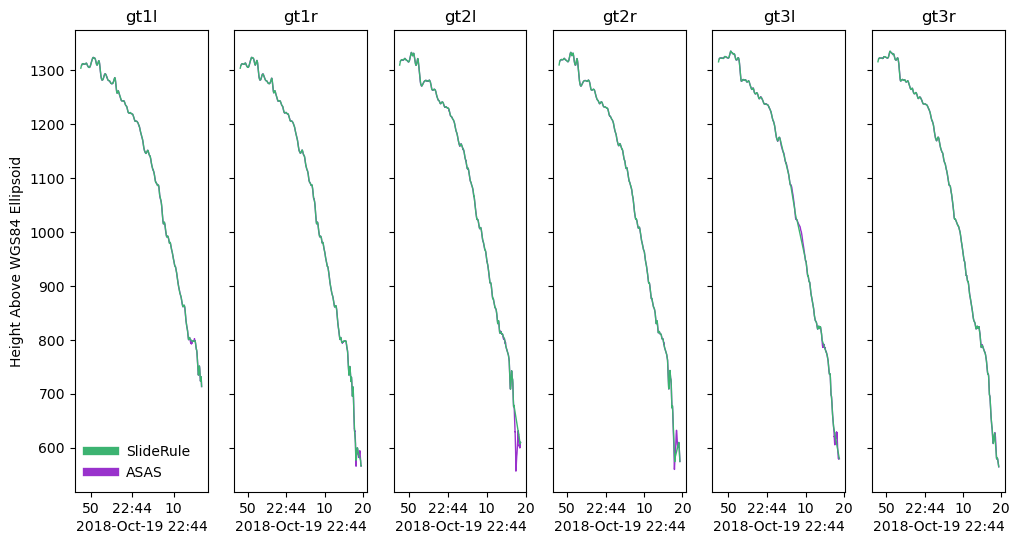

In [8]:
# Create Elevation Plot
fig,ax = plt.subplots(num=1, ncols=6, sharey=True, figsize=(12, 6))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
# Plot Elevations for each track
tracks = dict(gt1l=10,gt1r=20,gt2l=30,gt2r=40,gt3l=50,gt3r=60)
for s,gt in enumerate(tracks.keys()):
    sr = gdf[gdf["gt"] == tracks[gt]]
    asas = atl06[(atl06["gt"] == tracks[gt]) &
        (atl06["h_mean"] < 1e38) &
        (atl06["segment_id"] >= sr["segment_id"][0]) &
        (atl06["segment_id"] <= sr["segment_id"][-1])]
    ax[s].set_title(gt)
    ax[s].plot(sr.index.values, sr["h_mean"].values, zorder=1,
        linewidth=1.0, color='mediumseagreen', label='SlideRule')
    ax[s].plot(asas.index.values, asas["h_mean"].values, zorder=0,
        linewidth=1.0, color='darkorchid', label='ASAS')
    ax[s].xaxis.set_major_locator(locator)
    ax[s].xaxis.set_major_formatter(formatter)
# add labels and legends
ax[0].set_ylabel('Height Above WGS84 Ellipsoid')
lgd = ax[0].legend(loc=3,frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
# Show Plot
plt.show()

C:\Users\brely\AppData\Local\Temp\ipykernel_8924\3281158041.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


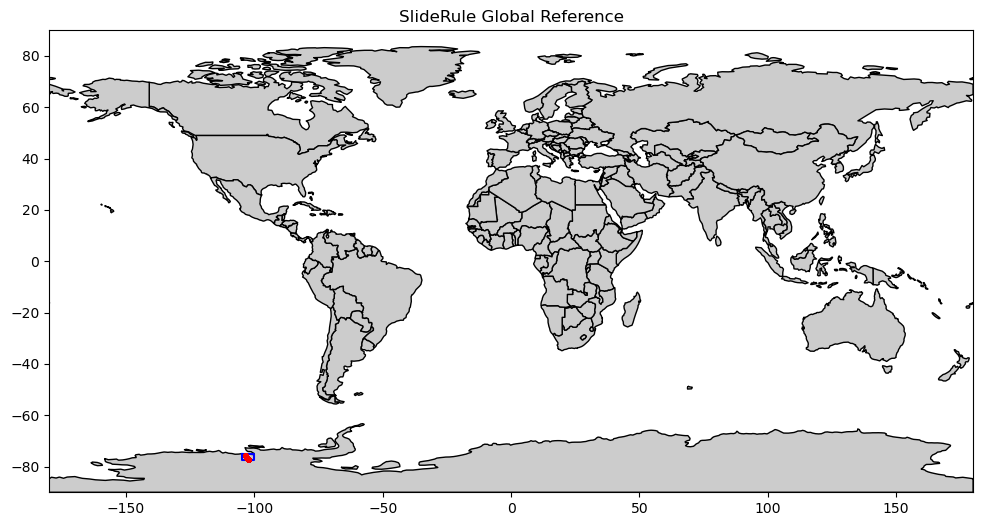

In [9]:
# Create PlateCarree Plot
fig,ax1 = plt.subplots(num=None, figsize=(12, 6))
################################
# add global plot
################################
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax1, color='0.8', edgecolor='black')
gdf.plot(ax=ax1, marker='o', color='red', markersize=2.5, zorder=3)
ax1.set_title("SlideRule Global Reference")

# Plot locations of each track
tracks = dict(gt1l=10,gt1r=20,gt2l=30,gt2r=40,gt3l=50,gt3r=60)
for s,gt in enumerate(tracks.keys()):
    sr = gdf[gdf["gt"] == tracks[gt]]
    sr.plot(ax=ax1, marker='o', color='red', markersize=2.5, zorder=3)

# Plot Bounding Box
ax1.plot(box_lon, box_lat, linewidth=1.5, color='blue', zorder=2)

# x and y limits, axis = equal
ax1.set_xlim(-180,180)
ax1.set_ylim(-90,90)
ax1.set_aspect('equal', adjustable='box')
# show plot
plt.show()